## Домашнее задание «Сохранение результатов эксперимента»

## Часть II

In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer, scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

## Загрузка датасета,   

подготовленного в части 1. (см. [zak15_hw2_KotovYA_standart.ipynb](https://github.com/vyysky/wine_quality/blob/main/code/zak15_hw2_KotovYA_standart.ipynb) )  

In [8]:
data = pd.read_csv('wine_cl_data.csv')

## Разделяю данные для обучения и для проверки

In [9]:
# Выделяю столбец quality в целевую переменную y.
X = data.drop(columns=['quality'])
y = data['quality']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Моделирование  
<b> Продолжение </b>

Исследование данных, предобработка, первый вариант моделей  
пп.4.1 - 4.4 и вывод по ним в файле [zak15_hw2_KotovYA_standart.ipynb](https://github.com/vyysky/wine_quality/blob/main/code/zak15_hw2_KotovYA_standart.ipynb)

<b>4.5</b> Модель: RandomForestClassifier(), нормализация: Normalizer()

In [13]:
# Базовая модель с дефолтными параметрами

rfc_norm = make_pipeline(
    Normalizer(),
    RandomForestClassifier(random_state=42)
)

rfc_norm.fit(X_train, y_train)
predictions = rfc_norm.predict(X_test)

rfc_norm.score(X_train, y_train) , rfc_norm.score(X_test, y_test)

(1.0, 0.6566125290023201)

In [14]:
predictions[:10]

array([6, 6, 5, 6, 6, 5, 6, 5, 6, 6], dtype=int64)

#### 4.5.1 Поиск параметров модели с помощью RandomizedSearchCV

Возможно, получится улучшить метрику, подобрав другие параметры.

In [65]:
rfc_n = Pipeline(
   [('norm', Normalizer()),
    ('rfc', RandomForestClassifier())]
)

In [66]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 15, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'rfc__n_estimators': n_estimators,
               'rfc__max_features': max_features,
               'rfc__max_depth': max_depth,
               'rfc__min_samples_split': min_samples_split,
               'rfc__min_samples_leaf': min_samples_leaf,
               'rfc__bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_n,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=42)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'rfc__n_estimators': 500,
 'rfc__min_samples_split': 23,
 'rfc__min_samples_leaf': 2,
 'rfc__max_features': 'log2',
 'rfc__max_depth': 15,
 'rfc__bootstrap': False}

In [81]:
rfc_norm = make_pipeline(
    Normalizer(),
    RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=23, min_samples_leaf=2, max_features='log2', bootstrap=False, random_state=42)
)

In [68]:
rfc_norm.fit(X_train, y_train)
predictions = rfc_norm.predict(X_test)

rfc_norm.score(X_train, y_train) , rfc_norm.score(X_test, y_test)

(0.8845261121856867, 0.6249033255993813)

#### 4.5.2  GridSearchCV()
Посмотрю, можно ли ешё улучшить модель.  
Проанализирую получившиеся варианту парметров и  
воспользуюсь GridSearchCV().


In [69]:
# Строю датафрейм наборов параметров, результатов RandomizedSearchCV

rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'params',
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_rfc__n_estimators,param_rfc__min_samples_split,param_rfc__min_samples_leaf,param_rfc__max_features,param_rfc__max_depth,param_rfc__bootstrap,mean_test_score,rank_test_score
0,500,23,2,log2,15,False,0.605224,1
1,400,12,2,log2,13,True,0.604449,2
2,900,28,7,log2,15,False,0.594392,3
3,900,7,7,sqrt,15,True,0.594005,4
4,600,34,2,sqrt,13,False,0.591877,5
5,300,12,12,sqrt,12,False,0.585494,6
6,1000,50,2,sqrt,15,False,0.584914,7
7,900,44,7,sqrt,15,False,0.582012,8
8,1000,28,7,sqrt,10,False,0.581626,9
9,700,7,2,sqrt,9,True,0.580465,10


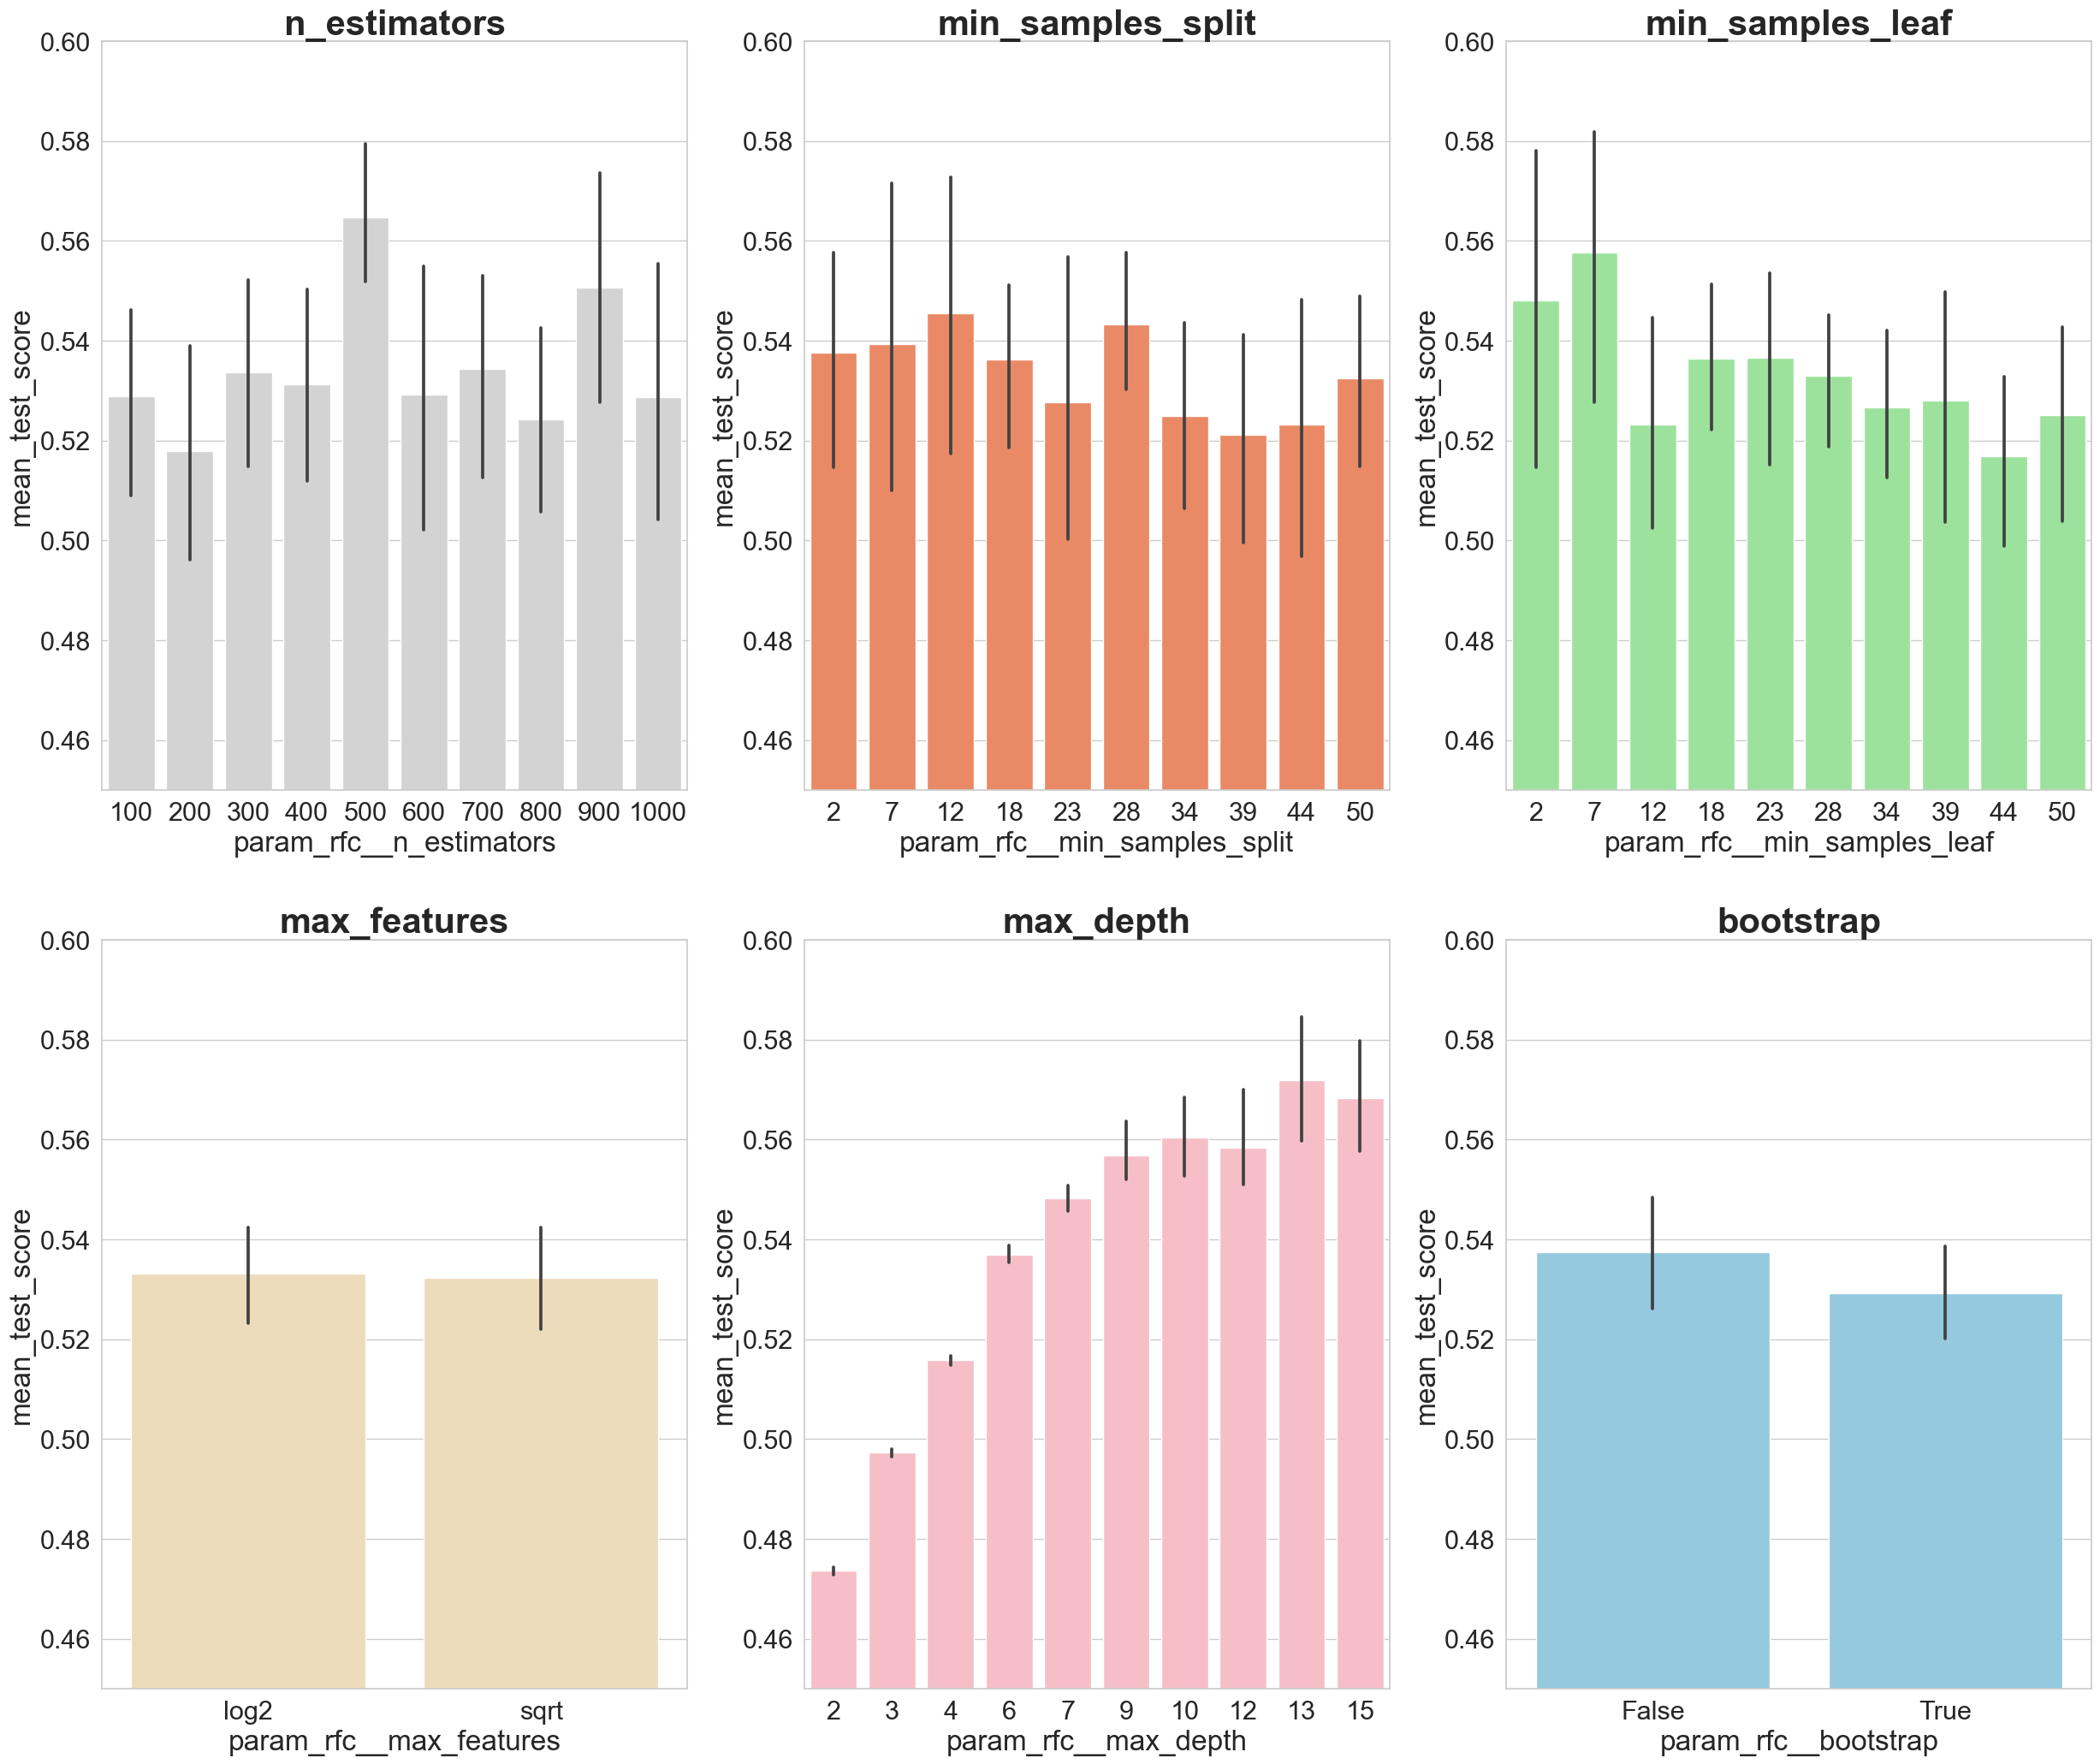

In [73]:
# посторою столбатые диаграммы параметров, где по оси y будут средние оценки модели для этих параметров
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_rfc__n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.45,.60]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_rfc__min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.45,.60]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_rfc__min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.45,.60]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_rfc__max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.45,.60]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_rfc__max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.45,.60]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_rfc__bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.45,.60])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

<b>Анализ значений параметров модели</b>  
* <b>max_features</b> и <b>bootstrap</b> в среднем, влияют на модель, практически одинаково  
* <b>n_estimators</b> лучшие показатели при значениях парамета = 500; 900  
* <b>min_samples_split</b> значения 12 и 28 показывают себя лучше  
* <b>min_samples_leaf</b> для этого парметра отмечу значения 2 и 7  
* <b>max_depth</b> с увеличением парметра росло качество модели.   
Лучшее у значения 13, но можно посмотреть 15. А ещё, возможно, 17.



In [77]:
from sklearn.model_selection import GridSearchCV

n_estimators = [500, 900]
max_features = ['log2', 'sqrt']
max_depth = [13,15,17]
min_samples_split = [12,28]
min_samples_leaf = [2,7]
bootstrap = [True, False]

param_grid = {'rfc__n_estimators': n_estimators,
               'rfc__max_features': max_features,
               'rfc__max_depth': max_depth,
               'rfc__min_samples_split': min_samples_split,
               'rfc__min_samples_leaf': min_samples_leaf,
               'rfc__bootstrap': bootstrap}
gs = GridSearchCV(rfc_n, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_best = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


{'rfc__bootstrap': False,
 'rfc__max_depth': 17,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 12,
 'rfc__n_estimators': 500}

In [85]:
rfc_best

Pipeline(steps=[('norm', Normalizer()),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, max_depth=17,
                                        max_features='sqrt', min_samples_leaf=2,
                                        min_samples_split=12,
                                        n_estimators=500))])

In [82]:
rfc_17 = make_pipeline(
    Normalizer(),
    RandomForestClassifier(n_estimators=500, max_depth=17, min_samples_split=12, min_samples_leaf=2, 
                           max_features='sqrt', bootstrap=False, n_jobs=-1, random_state=42)
)

In [83]:
rfc_17.fit(X_train, y_train)
predictions = rfc_17.predict(X_test)

rfc_17.score(X_train, y_train) , rfc_17.score(X_test, y_test)

(0.9531914893617022, 0.6481051817478731)

<b>Результат</b>  
Получилось только приблизиться снизу (0.648) к оценке базовой модели (0.657).   
Но это лучше, чем было у модели с DecisionTreeClassifier(): 0.56.